# Hyperparameter Tuning

Designing a well-defined process for machine learning is a critical step that takes your models from an environment such as this into a reusable state. It is especially necessary to have provenance and repeatability as you search for optimal hyperparameters to set up your machine learning models.

In this notebook, we will walk through a non-trivial image data analysis task. We will show how we can use **Grid Search** and **Random Search** for creating processes that would allow us to tune the parameters. 



## Face Data

(from SciKit Learn Docs)

This dataset is a collection of JPEG pictures of famous people collected over the internet, 
all details are available on the official website:

  *  http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. 
The typical task is called Face Verification: 
given a pair of two pictures, 
a binary classifier must predict whether the two images are from the same person.

An alternative task, 
Face Recognition or Face Identification is: 
given the picture of the face of an unknown person, 
identify the name of the person by referring to a gallery of previously seen pictures of identified persons.

Both Face Verification and Face Recognition are tasks that are typically 
performed on the output of a model trained to perform Face Detection. 
The most popular model for Face Detection is called Viola-Jones and is 
implemented in the OpenCV library. 
The LFW faces were extracted by this face detector from various online websites.

---

In [1]:
## Load some Libraries

from time import time
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC



## Load Data

In [2]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
#  Note: This is downloading 200 MB of data!  It may take a few moments.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


## Data Inspection

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Creating Train and Test sets 


In [4]:

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


The size of the feature vectors is too large. Let's use PCA to reduce the num of features.

## Apply PCA


In [5]:

n_components = 150  # Feel free to vary this number

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Transforming the input data ")

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 966 faces
Transforming the input data 


Now we have reduced the number of features to 150. Let's apply a classifer on this transformed data. We will be using SVC. 

# A. Train an SVC model with Grid Search

In the below code, we will be using _GridSearchCV_   

 * Please review the [Scikit Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [6]:

# The grid of hyperparameters: We are interested in parameters C and kernel
param_grid = {'C': [1e3, 5e3],
              'kernel': ['linear', 'rbf']}


# Defien the grid search object
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
                                                             
# Fit the grid search         
clf = clf.fit(X_train_pca, y_train)


In [7]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced')


The above GridSearch method learns 4 different models. We can learn about these models by probing `cv_results_` attribute.

In [8]:
clf.cv_results_

{'mean_fit_time': array([0.05895777, 0.12227731, 0.05784407, 0.12236967]),
 'std_fit_time': array([0.0025159 , 0.00029442, 0.00189983, 0.00025713]),
 'mean_score_time': array([0.00743766, 0.02786021, 0.00733376, 0.02730498]),
 'std_score_time': array([0.00018772, 0.00117125, 0.00016159, 0.00094148]),
 'param_C': masked_array(data=[1000.0, 1000.0, 5000.0, 5000.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1000.0, 'kernel': 'linear'},
  {'C': 1000.0, 'kernel': 'rbf'},
  {'C': 5000.0, 'kernel': 'linear'},
  {'C': 5000.0, 'kernel': 'rbf'}],
 'split0_test_score': array([0.7371134 , 0.79381443, 0.7371134 , 0.79381443]),
 'split1_test_score': array([0.75647668, 0.78238342, 0.75647668, 0.78238342]),
 'split2_test_score': array([0.75647668, 0.7305699

In [9]:
clf.best_params_

{'C': 1000.0, 'kernel': 'rbf'}

We can see from `cv_results_` that two models gave the same score in cross validated results: SVC with `{'C': 1000.0, 'kernel': 'rbf'}` and SVC with `{'C': 5000.0, 'kernel': 'rbf'}`. Here the first one is chosen as the best model. The following table shows the rank of each model in terms of cross-validated test scores. 

In [10]:
pd.DataFrame(
    {
        'Model': clf.cv_results_['params'],
        'Mean Test Score': clf.cv_results_['mean_test_score'],
        'Std Test Score': clf.cv_results_['std_test_score'],
        'Rank': clf.cv_results_['rank_test_score']
    }
)

,Model,Mean Test Score,Std Test Score,Rank
0,"{'C': 1000.0, 'kernel': 'linear'}",0.742241,0.017681,3
1,"{'C': 1000.0, 'kernel': 'rbf'}",0.783633,0.031566,1
2,"{'C': 5000.0, 'kernel': 'linear'}",0.742241,0.017681,3
3,"{'C': 5000.0, 'kernel': 'rbf'}",0.783633,0.031566,1


## Evaluating the best model. 

As this `GridSearchCV` stores the best model, we can simply call `predict` method on this object for evaluating a test set. We will now evaluate the best model in terms of precision, recall, f-1 scores, and accuracy.

In [11]:
y_pred = clf.predict(X_test_pca)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6
0,6,2,0,5,0,0,0
1,0,52,0,8,0,0,0
2,0,1,16,10,0,0,0
3,0,3,0,143,0,0,0
4,0,1,0,4,19,0,1
5,0,3,0,4,1,7,0
6,0,0,1,8,0,0,27


In [12]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.46      0.63        13
     Colin Powell       0.84      0.87      0.85        60
  Donald Rumsfeld       0.94      0.59      0.73        27
    George W Bush       0.79      0.98      0.87       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.93      0.70      0.77       322
     weighted avg       0.86      0.84      0.83       322



## Visualization

In this visualization, we show first 12 images from the test set and their predicted labels.

In [13]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

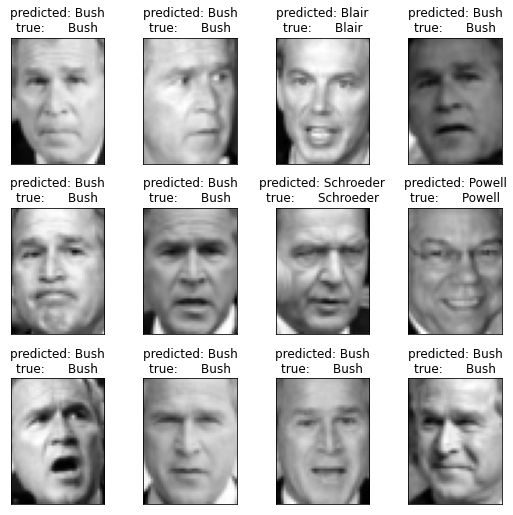

In [14]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)


We can also show the first 12 PCA components for these faces. 

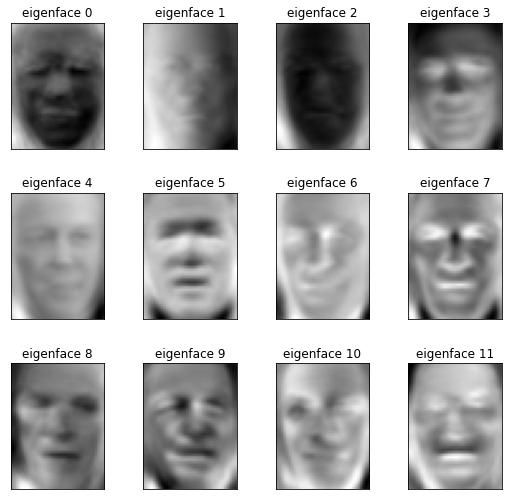

In [15]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# B. Train an SVC model with Random Search

Instead of using grid search we can also use sklearn **random search** to perform hyper parameter tuning. Random search samples a parameter from a parameter distribution/list to identify the best params. sklearn has function `RandomizedSearchCV` for searching through given params distribution. In the following code `n_iter` denotes the number of parameter settings that are tried.

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# parameter list and their distirbutions
param_grid = {'C': uniform(loc=10, scale = 1000),
              'kernel': ['linear', 'rbf']
              }


# build the Random searchable model.
random_clf = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced'), 
                                param_grid, n_iter=10, n_jobs=5)



# train the model. it will figure out the best hyper parameter for this dataset
random_clf = random_clf.fit(X_train_pca, y_train)

In [17]:
random_clf.cv_results_

{'mean_fit_time': array([0.16732202, 0.07439961, 0.16462135, 0.16409473, 0.07808051,
        0.16539526, 0.16042018, 0.07651391, 0.08032255, 0.16077924]),
 'std_fit_time': array([0.00219326, 0.01011547, 0.00826215, 0.00791141, 0.00843354,
        0.01037537, 0.01065023, 0.00852526, 0.01244292, 0.01051347]),
 'mean_score_time': array([0.02582107, 0.01237617, 0.03094668, 0.03182898, 0.01207051,
        0.03690133, 0.03576355, 0.01209164, 0.0078197 , 0.0345098 ]),
 'std_score_time': array([0.00055392, 0.00873669, 0.01033178, 0.01077919, 0.00808903,
        0.01062016, 0.01111856, 0.0088579 , 0.0004176 , 0.01050053]),
 'param_C': masked_array(data=[35.518685461476736, 978.5918268135794,
                    928.6747667246942, 830.3772822292253,
                    750.4703375375424, 52.54838480687661,
                    41.42313964729981, 202.08787409961238,
                    550.9183150449328, 630.1555813751509],
              mask=[False, False, False, False, False, False, False, False

In [18]:
random_clf.best_params_

{'C': 35.518685461476736, 'kernel': 'rbf'}

Random search may not give us the best parameter setting for the model. But the key reason for using random search is to figure out a sample point in some distribution with a good result when it is hard to manually pick some values for a parameter. Once we have found good setting with random search, we can narrow down our search for getting a better parameter setting.

In [19]:
y_pred = random_clf.predict(X_test_pca)
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6
0,6,2,0,5,0,0,0
1,0,52,0,8,0,0,0
2,0,1,16,10,0,0,0
3,0,3,0,143,0,0,0
4,0,1,0,4,19,0,1
5,0,3,0,4,1,7,0
6,0,0,1,8,0,0,27


In [20]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.46      0.63        13
     Colin Powell       0.84      0.87      0.85        60
  Donald Rumsfeld       0.94      0.59      0.73        27
    George W Bush       0.79      0.98      0.87       146
Gerhard Schroeder       0.95      0.76      0.84        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       0.96      0.75      0.84        36

         accuracy                           0.84       322
        macro avg       0.93      0.70      0.77       322
     weighted avg       0.86      0.84      0.83       322



# Save your notebook, then `File > Close and Halt`